# Dependencies

In [120]:
pip install eli5

# Libraries


In [121]:
#importing all necessary library
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import svm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import metrics, datasets
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# Random Forest

In [122]:
#Importing dataset
#files.upload() #Uncomment this while using the code first time to upload dataset file provided
data = pd.read_csv('Ahmedabad.csv')

#defining X and Y from the dataset
y = (data['precipInch']>=0.01)  # Convert the data to binary (if rain - True, No rain -False)
X = data.drop(['precipInch','precipMM','tempC','pressure','FeelsLikeC','maxtempC','totalSnow_cm','sunHour'],axis=1) #data dropped from the permutation importance

#splitting the dataset into train and test sets
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.1, random_state=1)
my_model = RandomForestClassifier(n_estimators=250,random_state=0).fit(train_X, train_y)

In [123]:
#Performing permutation importance
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0330 ± 0.0130,DewPointC
0.0176 ± 0.0105,cloudcover
0.0145 ± 0.0120,uvIndex
0.0118 ± 0.0044,visibility
0.0109 ± 0.0088,mintempC
0.0100 ± 0.0084,windspeedKmph
0.0086 ± 0.0101,humidity
0.0077 ± 0.0106,moon_illumination
0.0063 ± 0.0088,winddirDegree
0.0063 ± 0.0078,WindGustKmph


Accuracy Score =  0.9343891402714932


[Text(0, 0.5, 'label'), Text(0.5, 0, 'number of days')]

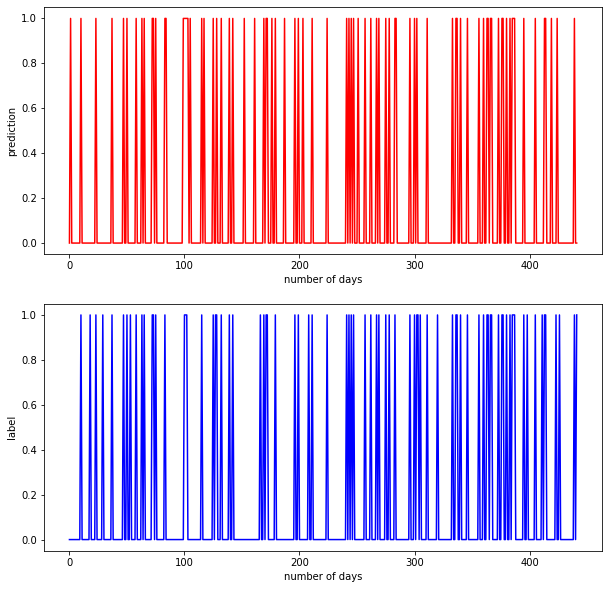

In [124]:
#Output For the Random forest with two classes
randomScorePI = my_model.score(val_X,val_y)
print("Accuracy Score = ",randomScorePI)
#print(my_model.predict_proba(val_X)) #uncomment this to see the prediction probability

rfc_pred = my_model.predict(val_X) #Predict the response for test dataset
fig, axs = plt.subplots(2,figsize=(10,10))

axs[0].plot(rfc_pred,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

val_y=val_y.reset_index(drop=True).rename_axis('row_id') #reset the axes as we splited data in random manner

axs[1].plot(val_y,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')


# Random Forest Chi squared

In [125]:
# Loading the rain data
data = pd.read_csv('Ahmedabad.csv')

#generate X(Features) and Y(label) data
Y_temp = data['precipInch']
X = data.drop(['precipInch','precipMM','DewPointC','totalSnow_cm'],axis=1)
Y = [] #to generate the classes we assign some ranges of the rainfall to classes

# Y has 4 outcomes 1,2,3,4 which simply mean ['No Rains', 'Drizzle', 'Moderate Rains', 'Heavy Rains'] respectivly

for i in range(Y_temp.size):
	if(Y_temp[i]<0.001):
		Y.append(1)
	elif(Y_temp[i]>=0.001 and Y_temp[i]<0.1):
		Y.append(2)
	elif(Y_temp[i]>=0.1 and Y_temp[i]<1.2):
		Y.append(3)
	else:
		Y.append(4)

In [126]:
# this loop will select the best k which gives highest accuracy
MaxScore = 0
new_k = 0
for i in range(3,X.shape[1]):
  test = SelectKBest(score_func=chi2, k=i).fit(X, Y) # selecting features with chi square
  X_new=test.fit_transform(X, Y) 
  train_X, val_X, train_y, val_y = train_test_split(X_new, Y,test_size=0.1, random_state=1,shuffle=False)
  my_model = RandomForestClassifier(n_estimators=100,random_state=0).fit(train_X, train_y)
  scoreChi = my_model.score(val_X,val_y)
  if (scoreChi>MaxScore):
    MaxScore = scoreChi
    new_k = i

print(new_k)

14


In [127]:
#train the model with best k so model predict with higher accuracy
test = SelectKBest(score_func=chi2, k=new_k).fit(X, Y)
X_new=test.fit_transform(X, Y) #creating new feature data
train_X, val_X, train_y, val_y = train_test_split(X_new, Y,test_size=0.1, random_state=1,shuffle=False)
my_model = RandomForestClassifier(n_estimators=250,random_state=0).fit(train_X, train_y) # train model with best features

Accuracy Score =  0.8371040723981901
[[0.992 0.008 0.    0.   ]
 [0.932 0.068 0.    0.   ]
 [0.872 0.116 0.012 0.   ]
 ...
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]]


[Text(0, 0.5, 'label'), Text(0.5, 0, 'number of days')]

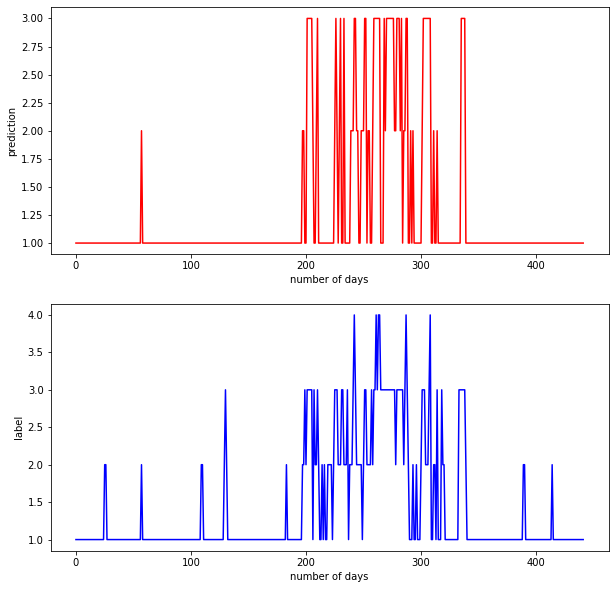

In [128]:
#comparing outcome to original labels
random_chi_score = my_model.score(val_X,val_y)
print("Accuracy Score = ",random_chi_score)
print(my_model.predict_proba(val_X)) #uncomment to see the prediction probability

#Predict the response for test dataset
rfc_pred = my_model.predict(val_X)
#print(rfc_pred)
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(rfc_pred,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

axs[1].plot(val_y,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')

# SVC With permutation importance

In [129]:
#Importing dataset
data = pd.read_csv('Ahmedabad.csv')

#genralising the X and Y
y = (data['precipInch']>=0.01)  # Convert the data to binary (if rain - True, No rain -False)
X = data.drop(['precipInch','precipMM','DewPointC','totalSnow_cm','moon_illumination','pressure','maxtempC'],axis=1)

# splitting into train test set
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.1, random_state=1) 

#Create a svm Classifier
clf = svm.SVC(kernel='linear').fit(train_X, train_y) # Linear Kernel is used #try polynomial by changing the 'linear' with 'poly'

#permutation Importance
perm = PermutationImportance(clf, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())


Weight,Feature
0.3158 ± 0.0436,HeatIndexC
0.1516 ± 0.0452,FeelsLikeC
0.0842 ± 0.0245,windspeedKmph
0.0810 ± 0.0231,WindGustKmph
0.0756 ± 0.0117,uvIndex
0.0747 ± 0.0317,WindChillC
0.0679 ± 0.0307,mintempC
0.0330 ± 0.0185,tempC
0.0213 ± 0.0102,humidity
0.0063 ± 0.0034,winddirDegree


Accuracy Score= 0.9117647058823529


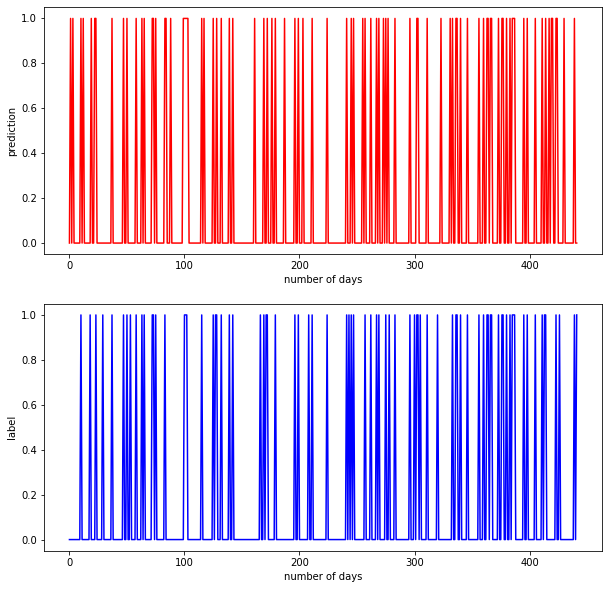

In [130]:
#Predict the response for validation dataset
y_pred = clf.predict(val_X)

#Plots to compare the predicted values and labeled values

fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(y_pred,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

val_y=val_y.reset_index(drop=True).rename_axis('row_id') # to reset the validation set as we have splitted the data in random manner
axs[1].plot(val_y,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')

#score
svc_perm_score = clf.score(val_X,val_y)
print("Accuracy Score=", svc_perm_score)

In [131]:
#data visualization
d = {'Prediction': y_pred,
     'Label': val_y}
df = pd.DataFrame(d)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Prediction', 'Label'))
L= len(df)

cnames = list(df.columns)
for k, name in enumerate(cnames):
    n_true = df[name].sum()
    fig.add_trace(go.Bar(x=['True', 'False'], y=[n_true, L-n_true], name=name ), 1,k+1)
fig.update_layout(barmode='relative',  bargap=0.05, width=700, height=400)


# SVC with chi squared Feature Selection

In [132]:
# Loading dataset
data = pd.read_csv('Ahmedabad.csv')

#generating X and Y data
Y_temp = data['precipInch']
X = data.drop(['precipInch','precipMM','DewPointC','totalSnow_cm'],axis=1) 
Y = [] #to generate the classes we assign some ranges of the rainfall to classes

for i in range(Y_temp.size):
	if(Y_temp[i]<0.001):
		Y.append(1)
	elif(Y_temp[i]>=0.001 and Y_temp[i]<0.1):
		Y.append(2)
	elif(Y_temp[i]>=0.1 and Y_temp[i]<1.2):
		Y.append(3)
	else:
		Y.append(4)

In [133]:
# Score function Chi2 tells the feature to be selected using Chi Square
# This loop will select the best k which gives highest accuracy
MaxScore2 = 0
new_k2 = 0
for j in range(3,X.shape[1]):
  test2 = SelectKBest(score_func=chi2, k=j).fit(X, Y)
  X_svc=test2.fit_transform(X, Y)
  train_X, val_X, train_y, val_y = train_test_split(X_svc, Y,test_size=0.1, random_state=1,shuffle=False)
  clf = svm.SVC(kernel='linear').fit(train_X, train_y) # Linear Kernel
  SVCscoreChi = clf.score(val_X,val_y)
  if (SVCscoreChi>MaxScore2):
    MaxScore2 = SVCscoreChi
    new_k2 = j
print(new_k2)

14


In [134]:
test2 = SelectKBest(score_func=chi2, k=new_k2).fit(X, Y) # selecting best 'new_k2' features to get highest accuracy 
X_svc=test2.fit_transform(X, Y) #transform the new X which has only best features
train_X, val_X, train_y, val_y = train_test_split(X_new, Y,test_size=0.1, random_state=1,shuffle=False) #splitting the data
clf = svm.SVC(kernel='linear').fit(train_X, train_y) #train model

Accuracy Score= 0.8212669683257918


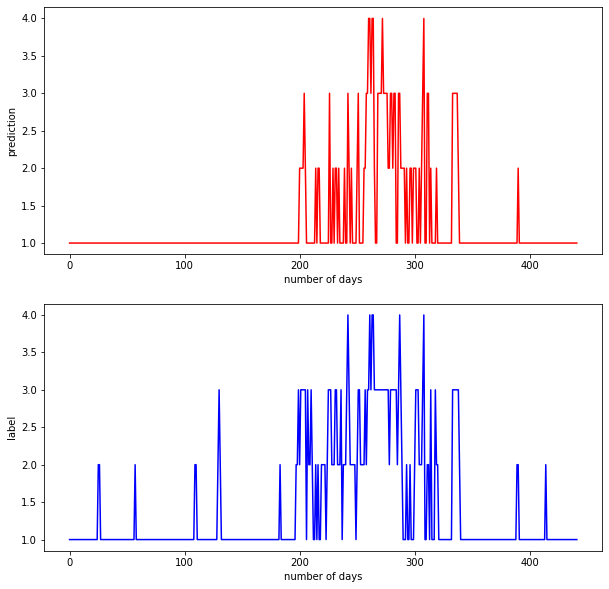

In [135]:
#Predict the response for test dataset
y_pred = clf.predict(val_X)

#plotting the both predicted and label graphs
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(y_pred,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

axs[1].plot(val_y,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')

#scoring
svc_chiScore = clf.score(val_X,val_y)
print("Accuracy Score=", svc_chiScore)

# Logistic Regression

In [136]:
data = pd.read_csv('Ahmedabad.csv')

Y_temp = data['precipInch']
X = data.drop(['precipInch','precipMM','DewPointC'],axis=1)


Y = []


for i in range(Y_temp.size):
	if(Y_temp[i]<0.001):
		Y.append(1)
	elif(Y_temp[i]>=0.001 and Y_temp[i]<0.1):
		Y.append(2)
	elif(Y_temp[i]>=0.1 and Y_temp[i]<1.2):
		Y.append(3)
	else:
		Y.append(4)

Y = np.array(Y).reshape(len(Y), ) #reshape the Y to (rows,)

In [137]:
#this loop will select the best k for better accuracy
MaxScore3 = 0
new_k3 = 0
for m in range(3,X.shape[1]):
  test3 = SelectKBest(score_func=chi2, k=m).fit(X, Y) # selecting features with chi square
  X_new=test3.fit_transform(X, Y)
  x_train, x_test, y_train, y_test = train_test_split(X_new, Y,test_size=0.1, shuffle=False)
  logr = LogisticRegression(multi_class='ovr', solver='liblinear').fit(x_train, y_train)
  scoreChi3 = logr.score(x_test,y_test)
  if (scoreChi3>MaxScore3):
    MaxScore3 = scoreChi3
    new_k3 = m

print(new_k3)

test3 = SelectKBest(score_func=chi2, k=new_k3).fit(X, Y) # selecting best 'new_k3' features with chi square to get high accuracy
X_new=test3.fit_transform(X, Y) #transform X into new X that has best features only
x_train, x_test, y_train, y_test = train_test_split(X_new, Y,test_size=0.1, shuffle=False)
logr = LogisticRegression(multi_class='ovr', solver='liblinear').fit(x_train, y_train) # trainning the data

14


0.8144796380090498


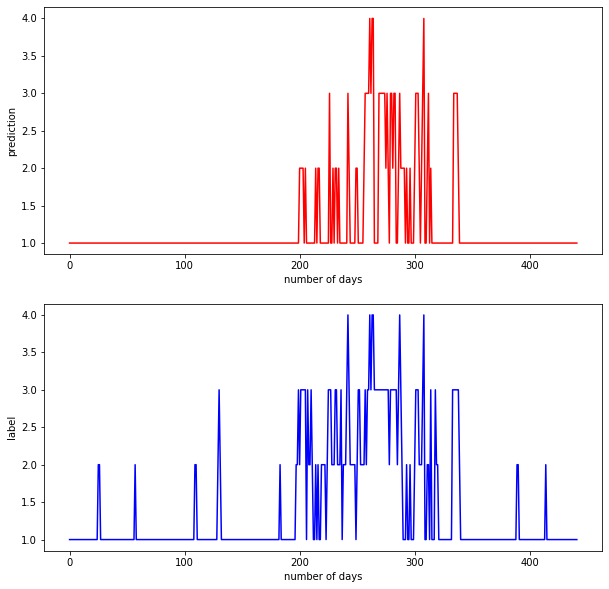

In [138]:
#predicting the test values
logisticY = logr.predict(x_test)

#plotting predicted values and labeled values
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(logisticY,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

#val_y=val_y.reset_index(drop=True).rename_axis('row_id')
axs[1].plot(y_test,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')
logistic_score = logr.score(x_test,y_test)
print(logistic_score)

# Gradient Boosting


In [139]:
# Generating Data
data = pd.read_csv('Ahmedabad.csv')
Y_temp = data['precipInch']
X = data.drop(['precipInch','precipMM','WindChillC','windspeedKmph','HeatIndexC','totalSnow_cm'],axis=1)

Y = []

for i in range(Y_temp.size):
	if(Y_temp[i]<0.001):
		Y.append(1)
	elif(Y_temp[i]>=0.001 and Y_temp[i]<0.1):
		Y.append(2)
	elif(Y_temp[i]>=0.1 and Y_temp[i]<1.2):
		Y.append(3)
	else:
		Y.append(4)

Y = np.array(Y).reshape(len(Y), )
  
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1 , random_state=1) #splitting into train test set

In [140]:
#normalize data
feature_names = X_val.columns.tolist()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(X_val.shape)

(442, 14)


In [141]:
#this loop will select the best learning rate at which machine predict well
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1] #learning rate list
maxaccu=[0,0]
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=2, random_state=1)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))
    if (maxaccu[0]<gb_clf.score(X_val, y_val)):
      maxaccu[0] = gb_clf.score(X_val, y_val)
      maxaccu[1] = learning_rate
print(maxaccu)
    

Learning rate:  0.05
Accuracy score (validation): 0.824
Learning rate:  0.075
Accuracy score (validation): 0.837
Learning rate:  0.1
Accuracy score (validation): 0.844
Learning rate:  0.25
Accuracy score (validation): 0.846
Learning rate:  0.5
Accuracy score (validation): 0.007
Learning rate:  0.75
Accuracy score (validation): 0.839
Learning rate:  1
Accuracy score (validation): 0.821
[0.8461538461538461, 0.25]


In [142]:
gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=maxaccu[1], max_features=X.shape[1], max_depth=2, random_state=1).fit(X_train, y_train)

#permutation Importance

perm = PermutationImportance(gb_clf2, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.0914 ± 0.0084,humidity
0.0403 ± 0.0044,cloudcover
0.0317 ± 0.0154,visibility
0.0276 ± 0.0180,uvIndex
0.0195 ± 0.0150,sunHour
0.0145 ± 0.0061,maxtempC
0.0140 ± 0.0018,moon_illumination
0.0136 ± 0.0040,WindGustKmph
0.0131 ± 0.0078,mintempC
0.0113 ± 0.0099,pressure


In [143]:
#Making prediction on validation set
pred = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, pred))

print("\n------------------Classification Report------------------")
print(classification_report(y_val, pred))

Confusion Matrix:
[[326  18   3   0]
 [ 15  24  10   1]
 [  7  10  22   3]
 [  0   1   0   2]]

------------------Classification Report------------------
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       347
           2       0.45      0.48      0.47        50
           3       0.63      0.52      0.57        42
           4       0.33      0.67      0.44         3

    accuracy                           0.85       442
   macro avg       0.59      0.65      0.61       442
weighted avg       0.85      0.85      0.85       442



Accuracy =  0.8461538461538461


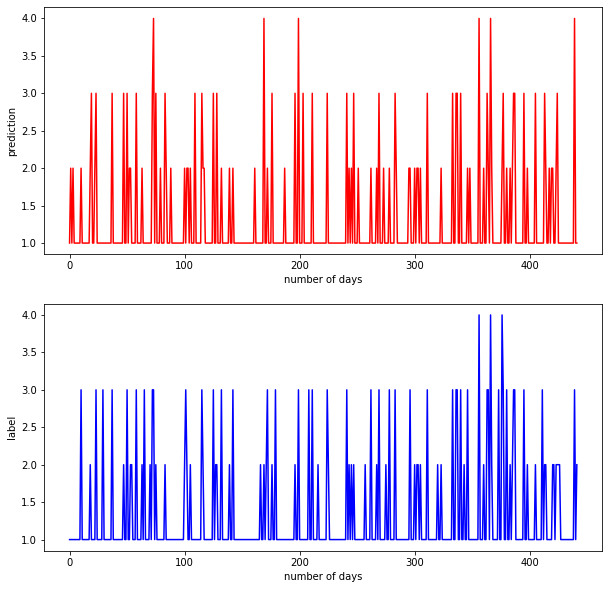

In [144]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(pred,color='red')
axs[0].set(xlabel='number of days', ylabel='prediction')

axs[1].plot(y_val,color='blue')
axs[1].set(xlabel='number of days', ylabel='label')
gradient_Score = gb_clf2.score(X_val,y_val)
print("Accuracy = ",gradient_Score)

# Comparission four classification

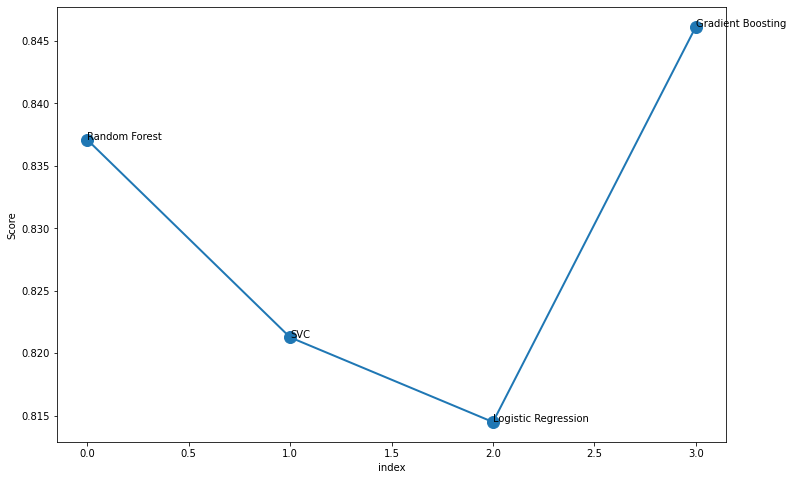

In [145]:
#Score Comparission between four classes models
scoreList = [random_chi_score,svc_chiScore,logistic_score,gradient_Score]
plt.figure(figsize=(12,8))
plt.plot(scoreList,"-o",linewidth=2, markersize=12)
plt.annotate("Random Forest", (0, random_chi_score))
plt.annotate("SVC", (1, svc_chiScore))
plt.annotate("Logistic Regression", (2, logistic_score))
plt.annotate("Gradient Boosting", (3, gradient_Score))
plt.xlabel('index')
plt.ylabel('Score');
plt.show()

# Comparission Two classification(rain, no rain)

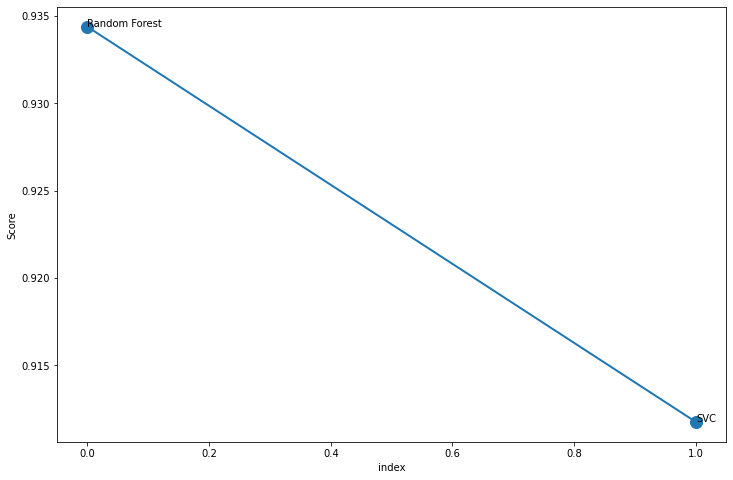

In [146]:
#Score Comparission between Two classes models
scoreList = [randomScorePI,svc_perm_score]
plt.figure(figsize=(12,8))
plt.plot(scoreList,"-o",linewidth=2, markersize=12)
plt.annotate("Random Forest", (0, randomScorePI))
plt.annotate("SVC", (1, svc_perm_score))
plt.xlabel('index')
plt.ylabel('Score');
plt.show()